In [50]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
# Add the project directory to the Python path
project_path = os.path.abspath('..')
if project_path not in sys.path:
    sys.path.append(project_path)

from p2p_lending.constants import random_state_for_split

files = ["probas","targets","aleatoric_log_variances","epistemic_variances"]
eval_name="Final Devset"

def load_data(path:str) -> dict[str,np.ndarray]:
    data:dict[str,np.ndarray] = {}
    for file in files:
        data[file] = np.load(os.path.join(path,file+f"_{eval_name}_{random_state_for_split}.npy"))
    return data

data = load_data("results/")

probas = data["probas"]
targets = data["targets"]
aleatoric_log_variances = data["aleatoric_log_variances"]
epistemic_variances = data["epistemic_variances"]
aleatoric_std = np.exp(0.5*aleatoric_log_variances)
epistemic_std = np.sqrt(epistemic_variances)
total_std= np.sqrt(aleatoric_std**2 + epistemic_std**2)

In [51]:
def _plot_probas_distr(probas):
    plt.hist(probas,bins=100)
    plt.title("Probas distribution")
    plt.show()

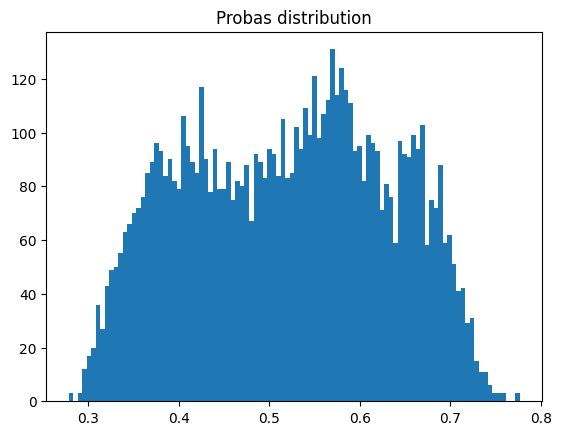

In [52]:
_plot_probas_distr(probas)

In [53]:
def _plot_auc_curve(probas,targets):
    from sklearn.metrics import roc_curve, roc_auc_score
    fpr, tpr, _ = roc_curve(targets, probas)
    auc = roc_auc_score(targets, probas)
    plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()

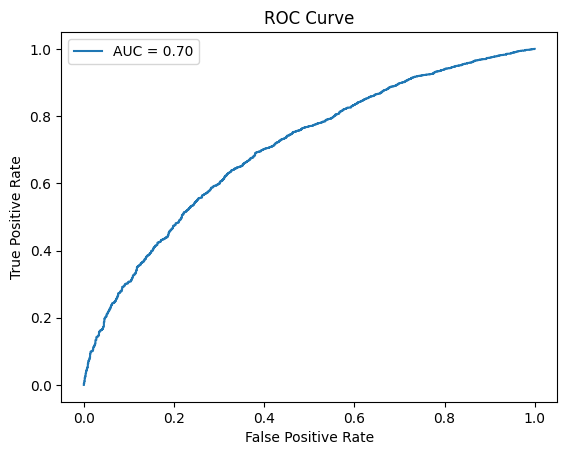

In [54]:
_plot_auc_curve(probas,targets)

In [55]:
def _plot_uncertainty_vs_error(uncertainty, error, title:str):
    plt.scatter(uncertainty, error, alpha=0.8, s=3)
    plt.xlabel(title)
    plt.ylabel("Error")
    plt.title(f"{title} vs Error")
    plt.show()

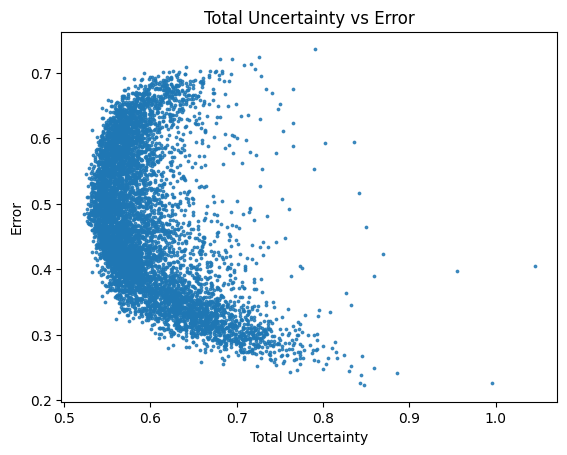

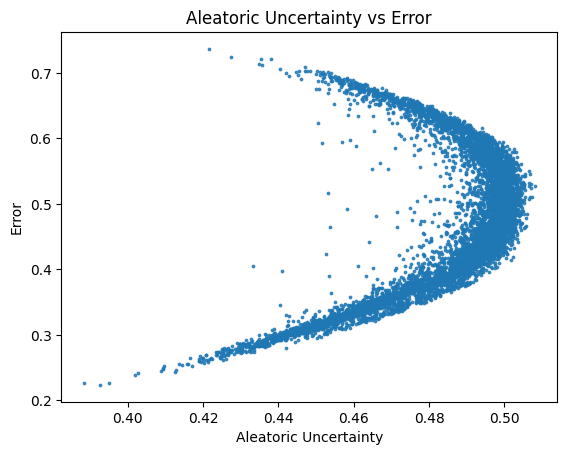

In [56]:
_plot_uncertainty_vs_error(total_std, np.abs(probas-targets), "Total Uncertainty")
_plot_uncertainty_vs_error(aleatoric_std, np.abs(probas-targets), "Aleatoric Uncertainty")

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

def _plot_auc_over_quantiles(probas, targets, uncertainty):
    auc_values = []
    thresholds = np.arange(1,0, -0.1)
    quantiles = np.quantile(uncertainty, thresholds)
    for quantile in quantiles:
        filtered_indices = np.where(uncertainty <= quantile)
        filtered_targets = targets[filtered_indices]
        filtered_probas = probas[filtered_indices]
        
        # Check if both classes are present
        if len(np.unique(filtered_targets)) < 2:
            print(f"Skipping quantile {quantile}: only one class present in targets.")
            continue
        
        auc = roc_auc_score(filtered_targets, filtered_probas)
        auc_values.append(auc)
    
    plt.xticks(thresholds)
    plt.plot(thresholds, auc_values,marker='o', linestyle='-')
    plt.gca().invert_xaxis()  # Invert the x-axis

    plt.xlabel('Percentage of data kept')
    plt.ylabel('AUC')
    plt.title('Area under the ROC curve for different quantiles of uncertainty')
    plt.show()

In [74]:
from sklearn.metrics import accuracy_score


def _plot_acc_over_quantiles_per_class(probas, targets, uncertainty):
    positive_class_indexes = np.where(targets == 1)[0]
    negative_class_indexes = np.where(targets == 0)[0]
    thresholds = np.arange(1,0, -0.1)
    
    probas_positive = probas[positive_class_indexes]
    uncertainty_positive = uncertainty[positive_class_indexes]
    
    probas_negative = probas[negative_class_indexes]
    uncertainty_negative = uncertainty[negative_class_indexes]
    
    acc_values_positive = []
    acc_values_negative = []
    quantiles_positive = np.quantile(uncertainty_positive, thresholds)
    quantiles_negative = np.quantile(uncertainty_negative, thresholds)
    
    for quantile in quantiles_positive:
        filtered_indices = np.where(uncertainty_positive <= quantile)
        filtered_probas = probas_positive[filtered_indices]
        
        acc = accuracy_score(np.ones_like(filtered_probas), filtered_probas > 0.5)
        acc_values_positive.append(acc)
        
    for quantile in quantiles_negative:
        filtered_indices = np.where(uncertainty_negative <= quantile)
        filtered_probas = probas_negative[filtered_indices]
        
        acc = accuracy_score(np.zeros_like(filtered_probas), filtered_probas > 0.5)
        acc_values_negative.append(acc)
        
    plt.xticks(thresholds)
    plt.plot(thresholds, acc_values_positive,marker='o', linestyle='-', label="Positive class")
    plt.plot(thresholds, acc_values_negative,marker='o', linestyle='-', label="Negative class")
    plt.gca().invert_xaxis()  # Invert the x-axis
    
    plt.xlabel('Proportion of most confident predictions kept')
    plt.ylabel('Accuracy')
    plt.title('Accuracy for different quantiles of uncertainty per class')
    plt.legend()
    plt.show()
    
    

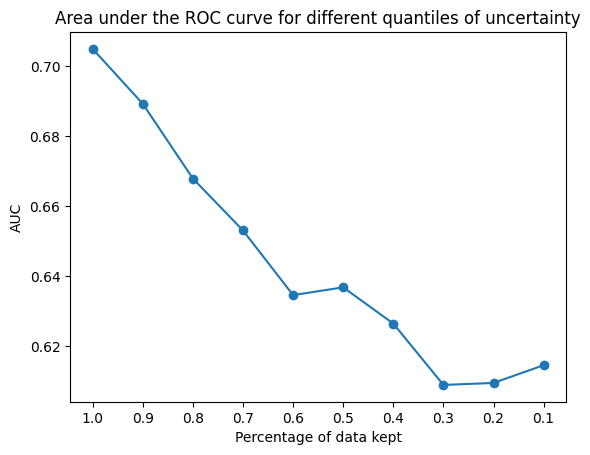

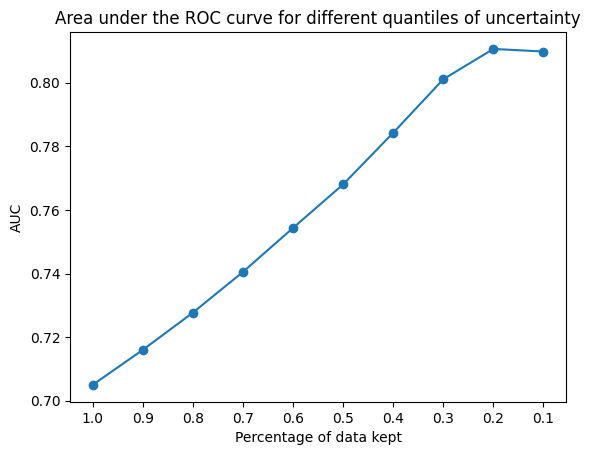

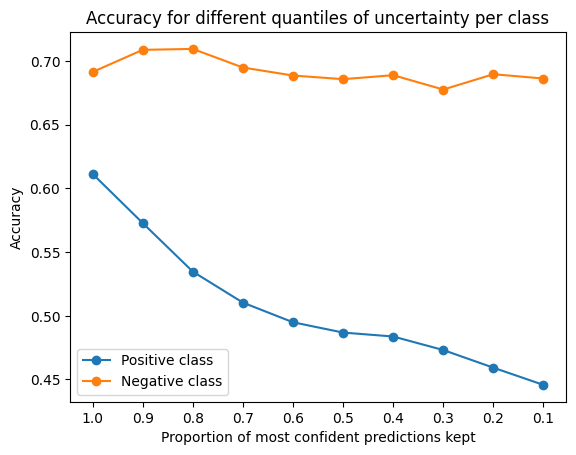

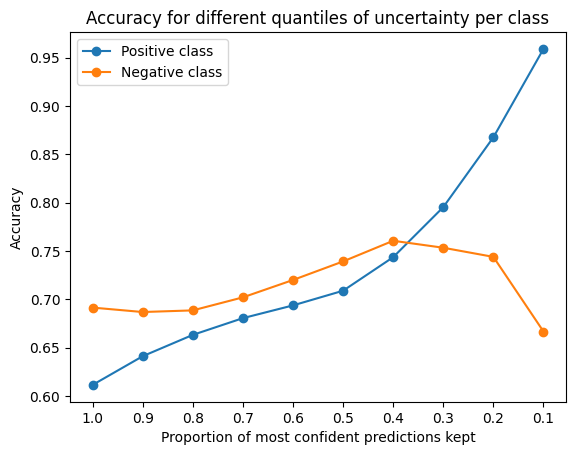

In [77]:
_plot_auc_over_quantiles(probas, targets, total_std)
_plot_auc_over_quantiles(probas, targets, aleatoric_std)
_plot_acc_over_quantiles_per_class(probas, targets, epistemic_std)
_plot_acc_over_quantiles_per_class(probas, targets, aleatoric_std)
